# Support Vector Machine (SVM)

### Učitavanje podataka

In [10]:
import joblib
X_train = joblib.load("../../data/processed/X_train.joblib")
y_train = joblib.load("../../data/processed/y_train.joblib")
X_test = joblib.load("../../data/processed/X_test.joblib")
y_test = joblib.load("../../data/processed/y_test.joblib")

### Unakrsna validacija

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

model = SVC(kernel='poly', cache_size=500, probability=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

scores = cross_validate(model, X_train, y_train, scoring=scoring_metrics)

print(scores)

{'fit_time': array([6584.91656685, 6679.92558575, 7538.99397278, 5376.44362998,
       4700.20865655]), 'score_time': array([ 76.68755603, 192.33907819,  70.63302684,  81.80730581,
        63.69920492]), 'test_accuracy': array([0.90726853, 0.89374929, 0.92012661, 0.9352401 , 0.84387476]), 'test_precision': array([0.99438876, 0.9960595 , 0.99721501, 0.94127743, 0.82780253]), 'test_recall': array([0.86865809, 0.84724317, 0.88511815, 0.96505782, 0.97301827]), 'test_f1': array([0.92728086, 0.9156441 , 0.93782878, 0.9530193 , 0.8945554 ]), 'test_roc_auc': array([0.87317979, 0.85325004, 0.89171303, 0.96362812, 0.94338363])}


In [ ]:
import pandas as pd

# Cuvanje rezultata validacije
cv_rezultati = pd.DataFrame(scores)
cv_rezultati.to_csv('cross_validation_rezultati.csv', index=False)

### Vizualizacija rezultata unakrsne validacije

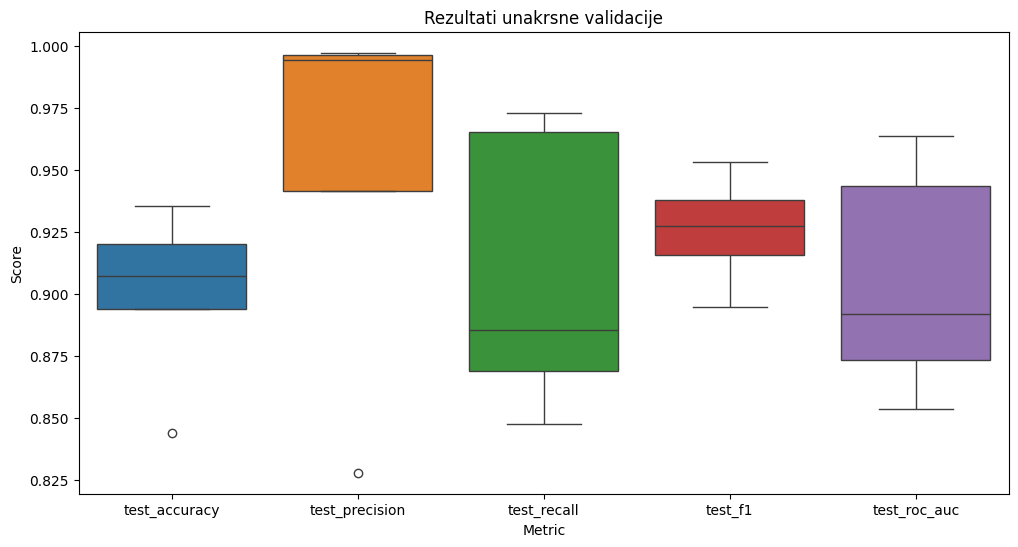

In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

scores_df = pd.read_csv('cross_validation_rezultati.csv')

# Uklanjanje fit_time i score_time kolona
scores_df.drop(columns=['fit_time', 'score_time'], inplace=True, errors='ignore')

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(scores_df, ax=ax)
plt.title('Rezultati unakrsne validacije')
plt.xlabel('Metric')
plt.ylabel('Score')
# plt.grid(True)
plt.show()

### Hyperparameter Tuning

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
import joblib
import time
import pandas as pd

# Distribucija parametara
param_dist = {
  'kernel': ['poly', 'rbf'],
  'C': loguniform(1e-3, 1e3), # 0.001 - 1000
  'gamma': ['scale', 'auto'],
  'degree': [2, 3], # poly kernel
  }

clf = SVC(cache_size=500, probability=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

random_search = RandomizedSearchCV(
  estimator=clf, 
  param_distributions=param_dist, 
  n_iter=1, # n_iter should be 20 - 30
  scoring=scoring_metrics, 
  n_jobs=-1, # paralelizacija
  refit="roc_auc", # najbolji model se bira na osnovu roc_auc metrike
  verbose=2, 
  random_state=42,
  return_train_score=True
  )

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

fit_time = end_time - start_time
print(f"Ukupno vrijeme izvršavanja fit metode: {fit_time:.2f} sekundi.")

# Cuvanje svih kombinacija parametara u CSV fajl
random_search_results_df = pd.DataFrame(random_search.cv_results_)
random_search_results_df.to_csv("random_search_rezultati.csv", index=False)

print('Najbolji parametri:', random_search.best_params_)
best_model = random_search.best_estimator_

joblib.dump(best_model, "svm_binary_model_tuned.joblib") # cuvanje najboljeg modela

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Ukupno vrijeme izvršavanja fit metode: 34869.22 sekundi.
Najbolji parametri: {'C': np.float64(0.1767016940294795), 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


['svm_binary_model_tuned.joblib']

### Treniranje modela

In [ ]:
import joblib

model.fit(X_train, y_train)

joblib.dump(model, 'svm_binary_model.joblib') # cuvanje modela

In [12]:
import joblib

clf = joblib.load('svm_binary_model.joblib') # klasifikator (trenirani model)

clf.get_params() # Parametri

{'C': 1.0,
 'break_ties': False,
 'cache_size': 500,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Evaluacija modela

In [13]:
import joblib

clf = joblib.load('svm_binary_model.joblib') # klasifikator (trenirani model)

y_pred = clf.predict(X_test)
print('Predikcije:', y_pred)

distance_values = clf.decision_function(X_test)
print('Udaljenost instanci od granice odlučivanja:', distance_values)

Predikcije: [1 1 1 ... 1 1 1]
Udaljenost instanci od granice odlučivanja: [0.50691722 0.4988705  0.51698959 ... 0.98871913 0.98871913 0.51402945]


### Vizualizacija udaljenosti uzoraka od granice odlučivanja

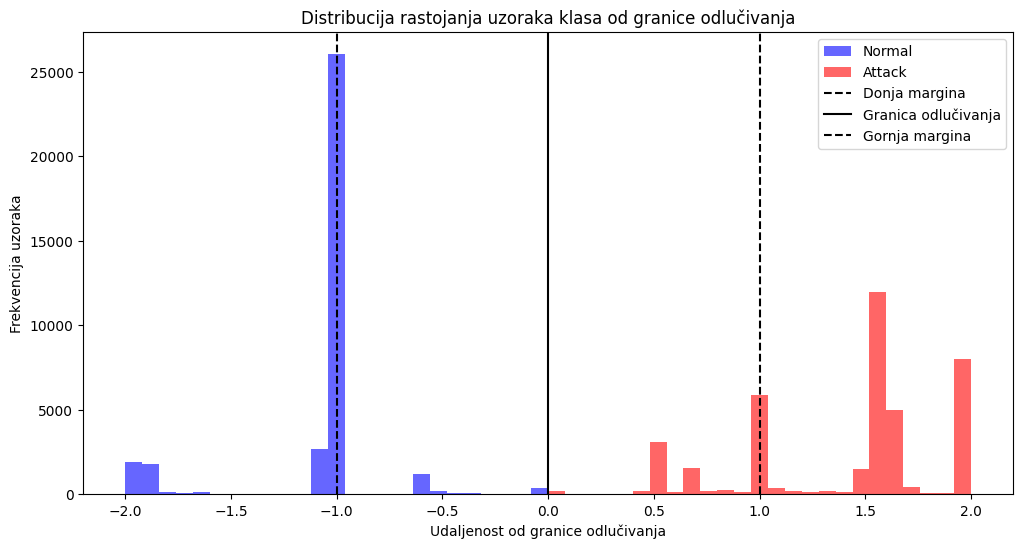

In [15]:
# Podjela klasa na osnovu distanci od granice odlucivanja
class_0_distances = distance_values[y_pred == 0]
class_1_distances = distance_values[y_pred == 1]

plt.figure(figsize=(12, 6))
# Histogrami za klase
plt.hist(class_0_distances, bins=50, range=(-2, 2), alpha=0.6, color='blue', label='Normal')
plt.hist(class_1_distances, bins=50, range=(-2, 2), alpha=0.6, color='red', label='Attack')
# Granica odlucivanja i margine
plt.axvline(-1, color="black", linewidth=1.5, linestyle="--", label="Donja margina")
plt.axvline(0, color="black", linewidth=1.5, linestyle="-", label="Granica odlučivanja")
plt.axvline(1, color="black", linewidth=1.5, linestyle="--", label="Gornja margina")
plt.title("Distribucija rastojanja uzoraka klasa od granice odlučivanja")
plt.xlabel('Udaljenost od granice odlučivanja')
plt.ylabel('Frekvencija uzoraka')
plt.legend()
plt.show()

### Metrike
- **Accuracy**: procenat tačnih predikcija(true positives i true negatives) od svih predikcija
- **Precision**: procenat stvarno pozitivnih instanci od predikcija pozitivnih instanci
- **Recall**: procenat tačno predviđenih instanci koje su stvarno pozitivne
- **f1 score**: harmonska srednja vrijednost preciznosti i recall-a(balans između preciznosti i recall-a)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Tačnost:", accuracy)
print("Preciznost:", precision)
print("Recall:", recall)
print("f1 skor:", f1)

# distance_values = clf.decision_function(X_test)
roc_auc = roc_auc_score(y_test, distance_values)
print("ROC AUC:", roc_auc) # prostor ispod ROC krive(sposobnost modela da razlikuje klase)

Tačnost: 0.8729291162609921
Preciznost: 0.8679978048883448
Recall: 0.9071737404041296
f1 skor: 0.8871534893754719
ROC AUC: 0.9408879134362458


### Matrica konfuzije (Confusion Matrix)

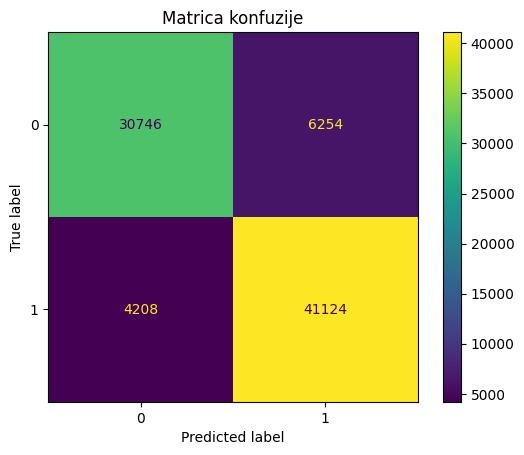

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# clf = joblib.load('svm_binary_model.joblib') # klasifikator (trenirani model)

conf_matrix = confusion_matrix(y_test, y_pred, labels=clf.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)

display.plot()
plt.title("Matrica konfuzije")
plt.show()

### ROC (Receiver Operating Characteristic) kriva
Ilustruje kompromis između stope istinskih pozitivnih rezultata(TPR) i stope lažnih pozitivnih rezultata(FPR).

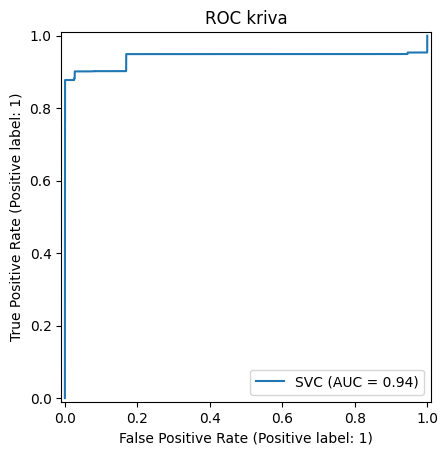

In [18]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(
   clf, X_test, y_test)

plt.title("ROC kriva")
plt.show()